<h1 align=center> EDA viviendas Cali </h1>

# Importando librerias y datos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
data = pd.read_excel("Datasets/Datos_Vivienda.xlsx")

# Parseando y limpiando data

Reduciendo dimension precios

In [620]:
data["precio(millonespesos)"] = data["Precio"]/1000000

Eliminando filas no necesarias

In [621]:
data.drop(["ID","URL","ciudad","Cordenada_latitud", "cordenada_longitud", "Precio"], inplace=True, axis=1)

Reduciendo valores unicos en Barrio

In [622]:
data["Barrio"] = data["Barrio"].str.replace(' ', '')
data["Barrio"] = data["Barrio"].str.lower()
data["Barrio"] = data["Barrio"].str.replace('1','')
data["Barrio"] = data["Barrio"].str.replace('2','')
data["Barrio"] = data["Barrio"].str.replace('3','')
data["Barrio"] = data["Barrio"].str.replace('4','')
data["Barrio"] = data["Barrio"].str.replace('5','')
data["Barrio"] = data["Barrio"].str.replace('6','')
data["Barrio"] = data["Barrio"].str.replace('7','')
data["Barrio"] = data["Barrio"].str.replace('8','')
data["Barrio"] = data["Barrio"].str.replace('9','')
data["Barrio"] = data["Barrio"].str.replace('0','')
data["Barrio"] = data["Barrio"].str.replace('los', '')
data["Barrio"] = data["Barrio"].str.replace('las', '')
data["Barrio"] = data["Barrio"].str.replace('el', '')
data["Barrio"] = data["Barrio"].str.replace('la', '')

Usando barrio para definir el estrato para valores nulos

In [623]:
est_null = data.loc[data["Estrato"].isna()]
est_replace = est_null["Barrio"].unique()

In [624]:
for i in est_replace:
    estrato = data.loc[data["Barrio"] == i]["Estrato"].iloc[0]
    if str(estrato).isnumeric():
        pass
    else:
        estrato = 3
    toreplace = data.loc[data["Barrio"] == i]
    finalreplace = toreplace["Estrato"].astype(str).str.replace('nan', str(estrato))
    data["Estrato"].fillna(finalreplace, inplace=True)

In [625]:
data["Estrato"] = data["Estrato"].astype('str')
data["Estrato"] = data["Estrato"].str.replace('Campestre', '6')

In [626]:
data["Estrato"] = data["Estrato"].astype('int')

Usando barrio para definir los valores vacios de zona

In [627]:
zon_null = data.loc[data["Zona"].isna()]
zon_replace = zon_null["Barrio"].unique()

In [628]:
for i in zon_replace:
    zona = data.loc[data["Barrio"] == i]["Zona"].iloc[0]
    if type(zona) == str:
        pass
    else:
        zona = "Zona Centro"
    toreplace = data.loc[data["Barrio"] == i]
    finalreplace = toreplace["Zona"].astype(str).str.replace('nan', zona)
    data["Zona"].fillna(finalreplace, inplace=True)


Existe un error en el tipo en area construida y area privada también pero no se toma en cuenta por sus valores atipicos frecuentes

In [629]:
todrop = data.loc[data["Area_contruida"] =="-"]
data.drop(todrop.index, inplace=True, axis=0)

In [630]:
data["Area_construida"] = data["Area_contruida"].astype('str')

In [631]:
todrop = data.loc[data["Area_construida"] =="57,40 a 60,50 "]
data.drop(todrop.index, inplace=True, axis=0)

In [632]:
data["Area_construida"] = data["Area_construida"].astype("float")

In [637]:
data["precio(mill)"] = data["precio(millonespesos)"]
data.drop(["precio(millonespesos)"], inplace=True, axis=1)

# Analisis exploratorio de datos

Analisis de la correlación por tipo de propiedad

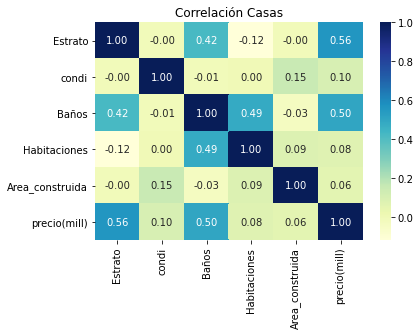

In [654]:
sns.heatmap(data.loc[data["Tipo"]=="Casa"].corr(), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Correlación Casas")
plt.show()

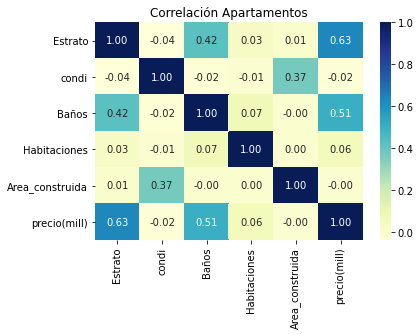

In [661]:
sns.heatmap(data.loc[data["Tipo"]=="Apartamento"].corr(), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Correlación Apartamentos")
plt.show()

<font color="red">Nota:</font> Muestra similitud en las variables, estrato, baños y habitaciones. Pero una fuerte diferencia entre area construida y condi

In [550]:
tipo_estrato_ind = data.pivot_table("precio(mill)","Estrato", "Tipo", 
                                    aggfunc={ max,"mean", min}).unstack().reset_index()

In [551]:
tipo_estrato_ind= tipo_estrato_ind.rename(columns={"level_0":"Indicador", 0:"precio(mill)"}, errors="raise")

In [552]:
tipo_estrato_ind.head(1)

,Indicador,Tipo,Estrato,precio(mill)
0,max,Apartamento,1,240.0


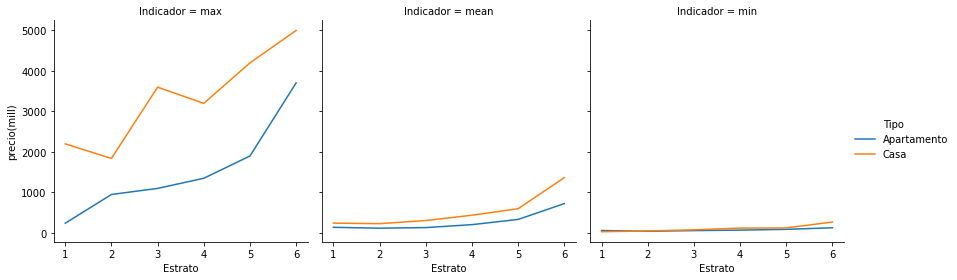

In [657]:
sns.relplot(data=tipo_estrato_ind,x="Estrato", y="precio(mill)", hue="Tipo", 
            col="Indicador", kind="line",height=4, aspect=1,col_wrap=3 )
plt.show()

<font color="red">Nota:</font> Se presenta una estandarización de las variables en el promedio y el minimo a lo largo de los estratos pero una fuerte variación en los maximos en las casas

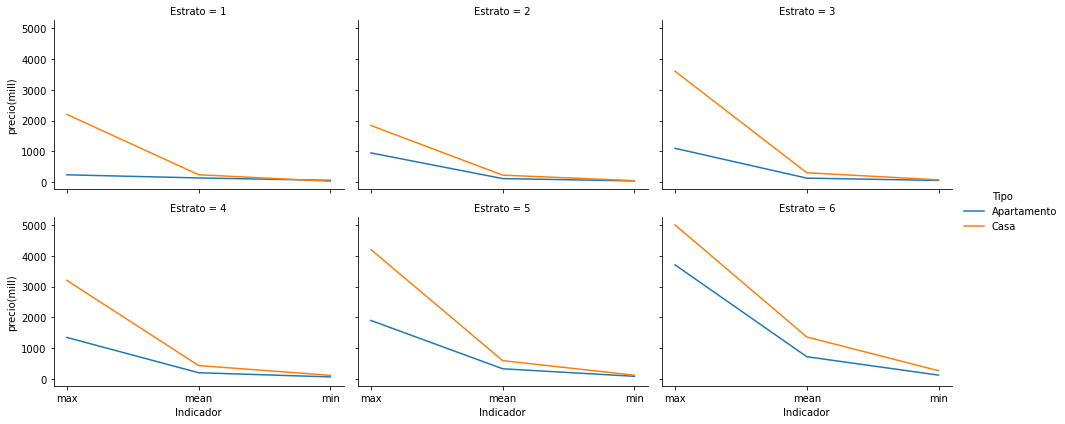

In [671]:
sns.relplot(data=tipo_estrato_ind,x="Indicador", y="precio(mill)", hue="Tipo", 
            col="Estrato", kind="line",height=3, aspect=1.5,col_wrap=3, 
            col_order=[1,2,3,4,5,6])
plt.show()

<font color="red">Nota:</font> Los máximos estan muy alejados de la media en cada uno de los estratos

In [662]:
tipo_baño = data.pivot_table("precio(mill)","Baños", "Tipo",
                             aggfunc={ max,"mean", min}).unstack().reset_index()

In [663]:
tipo_baño= tipo_baño.rename(columns={"level_0":"Indicador", 0:"precio(mill)"}, errors="raise")

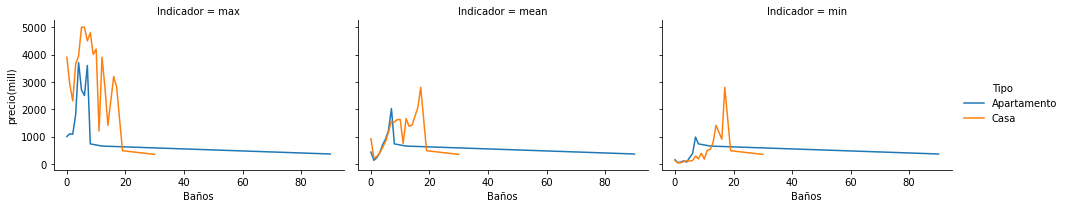

In [672]:
sns.relplot(data=tipo_baño,x="Baños", y="precio(mill)", hue="Tipo", 
            col="Indicador",height=3, aspect=1.5,col_wrap=3,kind="line")
plt.show()

<font color="red">Nota:</font> La grafica de minimos esta presentando valores atipicos en casas y apartamentos

In [694]:
tipo_area = data.pivot_table("precio(mill)","Area_contruida", "Tipo",
                             aggfunc={ max,"mean", min}).unstack().reset_index()

In [696]:
tipo_area= tipo_area.rename(columns={"level_0":"Indicador", 0:"precio(mill)"}, errors="raise")

In [698]:
tipo_area.dropna(axis=0, inplace=True)

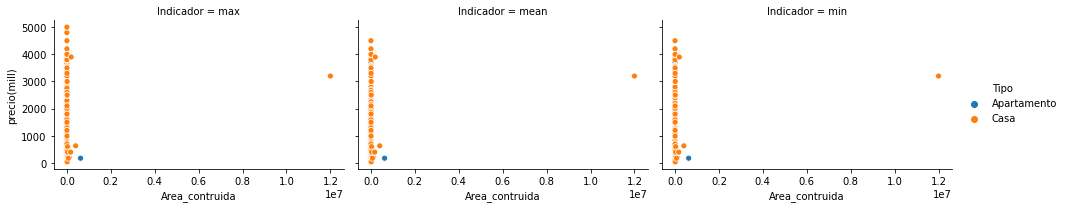

In [699]:
sns.relplot(data=tipo_area,x="Area_contruida", y="precio(mill)", hue="Tipo", 
            col="Indicador",height=3, aspect=1.5,col_wrap=3)
plt.show()

<font color="red">Nota:</font> Valor atipico no deja percibir la información más cercana